# Problem Statement

West Nile is an infection carried by mosquitoes. People get West Nile Virus from the bite of a mosquito that is infected with West Nile Virus. Mosquitoes become infected when they feed on a bird that has the virus in its blood. Once infected the mosquito can spread the virus to humans and other animals. In Illinois, West Nile virus was first identified in September 2001 when laboratory tests confirmed its presence in two dead crows found in the Chicago area. The following year, the state’s first human cases and deaths from West Nile disease were recorded and by the end of 2002, Illinois had counted more human cases (884) and 67 than any other state in the United States. The battle against the West Nile virus has since become an  annual affair that Chicago grapples with.

The goal of this project is to predict possible locations within Chicago where the West Nile Virus may occur in for effective mosquito control to assist with efforts in preventing virus spread. This project also aims to examine the main factors in the virus being spread, as well as discuss the costs and benefits of the current intervention method (spraying).

# Executive Summary

Based on the data provided, the period of study ranges from 2007 to 2014 with training data from the odd numbered years and test data from the even numbered years. Weather data is available for the entire period. Spray data from a few dates in 2011 and 2013 was also available. Based on the available data, this project aims to create a model to predict where the virus may surface so that mosquito control efforts may be targeted to those areas. Datasets will be cleaned, explored and merged appropriately followed by the development of various classification models. The best performing model will then be used predict the presence of West Nile Virus and benchmarked against other models on Kaggle.

### Contents

- Data Cleaning and EDA<br>
    - [Data Cleaning and Preprocessing Train Dataset](#Data-Cleaning-and-Preprocessing-Train-Dataset)<br>
    - [Data Cleaning and Preprocessing Spray Dataset](#Data-Cleaning-and-Preprocessing-Spray-Dataset)<br>
    - [Data Cleaning and Preprocessing Weather Dataset](#Data-Cleaning-and-Preprocessing-Weather-Dataset)<br>
    - [Feature Engineering](#Feature-Engineering)<br>
    - [Prep for EDA](#Prep-for-EDA)<br>
    - [EDA](#EDA)<br>
    - [Prep for Modelling](#Prep-for-Modelling)<br>
<br>    
- <a href = "Project_4-Modeling.ipynb">Modeling</a>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, datetime
from matplotlib.lines import Line2D

from sklearn.feature_extraction.text import CountVectorizer

## Data Cleaning and Preprocessing Train Dataset

[top](#Contents)

#### Importing Train Dataset

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### Checking for null entries

In [4]:
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

- No null values observed

### Dropping irrelevant columns

In [5]:
train['AddressAccuracy'].value_counts()

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

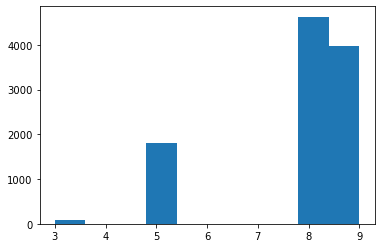

In [6]:
plt.hist(train['AddressAccuracy']);

- Examining AddressAccuracy column, most data lies in 8 and 9
- Understanding that 'Latitude' and 'Longitude provides information on the location already, all other features that contain location information are dropped

In [7]:
train.drop(columns = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace = True)

### Converting to appropriate datatypes

- Convert date from String to Datetime

In [8]:
train['Date'] = pd.to_datetime(train['Date'])

In [9]:
train.dtypes

Date            datetime64[ns]
Species                 object
Trap                    object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
dtype: object

- All columns are in the appropriate datatype

### Merging rows

- As entries are split once number of mosquitoes exceed 50, we group the date entries by trap locations and species to sum common entries together

In [10]:
train_new = train.groupby(['Date','Trap', 'Latitude', 'Longitude', 'Species']).sum()
train_new

NumMosquitos  \
Date       Trap Latitude  Longitude  Species                                
2007-05-29 T002 41.954690 -87.800991 CULEX PIPIENS/RESTUANS             1   
                                     CULEX RESTUANS                     1   
           T007 41.994991 -87.769279 CULEX RESTUANS                     1   
           T015 41.974089 -87.824812 CULEX PIPIENS/RESTUANS             1   
                                     CULEX RESTUANS                     4   
...                                                                   ...   
2013-09-26 T232 41.912563 -87.668055 CULEX PIPIENS/RESTUANS             1   
           T233 42.009876 -87.807277 CULEX PIPIENS/RESTUANS             5   
           T235 41.776428 -87.627096 CULEX PIPIENS/RESTUANS             1   
           T900 41.974689 -87.890615 CULEX PIPIENS                     37   
                                     CULEX PIPIENS/RESTUANS            43   

                                                             WnvPresent  
Date       Trap Latitude  Longitude  Species                             
2007-05-29 T002 41.954690 -87.800991 CULEX PIPIENS/RESTUANS           0  
                                     CULEX RESTUANS                   0  
           T007 41.994991 -87.769279 CULEX RESTUANS                   0  
           T015 41.974089 -87.824812 CULEX PIPIENS/RESTUANS           0  
                                     CULEX RESTUANS                   0  
...                                                                 ...  
2013-09-26 T232 41.912563 -87.668055 CULEX PIPIENS/RESTUANS           0  
           T233 42.009876 -87.807277 CULEX PIPIENS/RESTUANS           0  
           T235 41.776428 -87.627096 CULEX PIPIENS/RESTUANS           0  
           T900 41.974689 -87.890615 CULEX PIPIENS                    0  
                                     CULEX PIPIENS/RESTUANS           1  

[8475 rows x 2 columns]

In [11]:
train_new = train_new.reset_index()
train_new.head()

,Date,Trap,Latitude,Longitude,Species,NumMosquitos,WnvPresent
0,2007-05-29,T002,41.954690,-87.800991,CULEX PIPIENS/RESTUANS,1,0
1,2007-05-29,T002,41.954690,-87.800991,CULEX RESTUANS,1,0
2,2007-05-29,T007,41.994991,-87.769279,CULEX RESTUANS,1,0
3,2007-05-29,T015,41.974089,-87.824812,CULEX PIPIENS/RESTUANS,1,0
4,2007-05-29,T015,41.974089,-87.824812,CULEX RESTUANS,4,0


In [12]:
train_new['WnvPresent'].value_counts()

0     8018
1      409
2       31
3        9
4        2
7        1
6        1
5        1
10       1
9        1
8        1
Name: WnvPresent, dtype: int64

- Due to grouping of the data by Date, Trap and Species, the value of the WnvPresent column was also summed as a result. Since this is a binary column of whether the virus is present or not, all values above 1 can simply be mapped to 1

In [13]:
train_new['WnvPresent'] = train_new['WnvPresent'].map(lambda x : 1 if x > 0 else x)

In [14]:
train_new['WnvPresent'].value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

## Data Cleaning and Preprocessing Spray Dataset

[top](#Contents)

### Importing Spray Dataset

In [15]:
spray = pd.read_csv('./data/spray.csv')

In [16]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


### Changing Datetime for Spray

In [17]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [18]:
spray.Date = pd.to_datetime(spray.Date)

In [19]:
spray['Time'] = spray['Time'].map(lambda t: pd.to_datetime(t, format='%I:%M:%S %p'))

<ipython-input-20-8800ea60c7d5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['0000', '0300', '0600', '0900', '1200', '1500', '1800', '2100', '2400']);


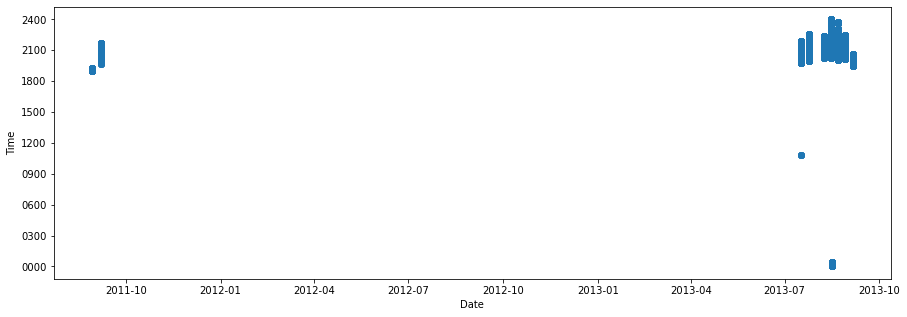

In [20]:
plt.figure(figsize=(15,5))
plt.scatter(spray['Date'], spray['Time'])
plt.ylabel('Time',fontsize=10)
plt.xlabel('Date',fontsize=10)
plt.gca().set_yticklabels(['0000', '0300', '0600', '0900', '1200', '1500', '1800', '2100', '2400']);

- Sprays were mainly done after sunset. During this timeframe the mosquito is active, and minimizes the risk of exposure to the public or beneficial insects.

## Data Cleaning and Preprocessing Weather Dataset

[top](#Contents)

### Importing Weather Dataset

In [21]:
weather = pd.read_csv('data/weather.csv')
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


### Checking for null entries

- Based on the weather data dic, missing data is represented by 'M'  and trace values is represented by 'T'. '-' are taken to be missing values as well.
- To investigate columns with M and - values by replacing these entries with np.NaN and doing a sum of all nan values for a quick overview

In [22]:
for col in weather.columns:
    
    weather[col].replace('M', np.nan, inplace=True)
    weather[col].replace('-', np.nan, inplace=True)

In [23]:
weather.isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

### Converting to Correct Datatype

In [24]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   object 
 5   Depart       1472 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   object 
 8   Heat         2933 non-null   object 
 9   Cool         2933 non-null   object 
 10  Sunrise      1472 non-null   object 
 11  Sunset       1472 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   object 
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   object 
 16  PrecipTotal  2942 non-null   object 
 17  StnPressure  2940 non-null   object 
 18  SeaLevel     2935 non-null   object 
 19  Result

- 'T' values signifiy trace readings (i.e. close to 0) and are thus replaced with 0.

In [25]:
for col in weather.columns:
    weather[col].replace('  T', 0, inplace=True)

- Converting columns to float for some visualizations

In [26]:
cols_to_float = [
                 'Depart',
                 'Tavg',
                 'WetBulb',
                 'Cool',
                 'Heat', 
                 'Depth', 
                 'SnowFall', 
                 'PrecipTotal', 
                 'StnPressure', 
                 'SeaLevel', 
                 'ResultSpeed',
                 'ResultDir', 
                 'AvgSpeed'
                ]


In [27]:
for col in cols_to_float:
    weather[col] = weather[col].astype(float)

### Dropping Station 2

- Looking at the correlation values of the data from station 1 and station 2 as well as the subsequent visualizations below, there seems to be no significant difference between values from the two stations with the exception of PrecipTotal

- Seeing as station 1 contains almost no null values, and station 2 contains a large number of null values, we elected to drop station 2 entirely while taking the average of PrecipTotal between both stations

In [28]:
weather['Date'] = weather['Date'].astype('datetime64[ns]')
weather['month'] = weather['Date'].dt.month
weather['year'] = weather['Date'].dt.year

In [29]:
station1 = weather[weather["Station"] == 1]
station2 = weather[weather["Station"] == 2]

In [30]:
station1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Date         1472 non-null   datetime64[ns]
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   float64       
 5   Depart       1472 non-null   float64       
 6   DewPoint     1472 non-null   int64         
 7   WetBulb      1469 non-null   float64       
 8   Heat         1472 non-null   float64       
 9   Cool         1472 non-null   float64       
 10  Sunrise      1472 non-null   object        
 11  Sunset       1472 non-null   object        
 12  CodeSum      1472 non-null   object        
 13  Depth        1472 non-null   float64       
 14  Water1       0 non-null      float64       
 15  SnowFall     1472 non-null   float64       
 16  Precip

In [31]:
station2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 1 to 2943
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Date         1472 non-null   datetime64[ns]
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1461 non-null   float64       
 5   Depart       0 non-null      float64       
 6   DewPoint     1472 non-null   int64         
 7   WetBulb      1471 non-null   float64       
 8   Heat         1461 non-null   float64       
 9   Cool         1461 non-null   float64       
 10  Sunrise      0 non-null      object        
 11  Sunset       0 non-null      object        
 12  CodeSum      1472 non-null   object        
 13  Depth        0 non-null      float64       
 14  Water1       0 non-null      float64       
 15  SnowFall     0 non-null      float64       
 16  Precip

In [32]:
weather_cols = [
                'Tmax', 
                'Tmin', 
                'Tavg', 
                'Depart', 
                'DewPoint',
                'WetBulb', 
                'Heat', 
                'Cool', 
                'Depth',
                'Water1', 
                'SnowFall', 
                'PrecipTotal', 
                'StnPressure', 
                'SeaLevel',
                'ResultSpeed', 
                'ResultDir', 
                'AvgSpeed']

In [33]:
# Checking that station 1 and station 2 have the same columns

station1.reset_index(drop = True, inplace = True)
station2.reset_index(drop = True, inplace = True)
station1[weather_cols].corrwith(station2[weather_cols]).to_frame(name = 'Correlation').sort_values(by = 'Correlation', 
                                                                                           ascending = False)

,Correlation
StnPressure,0.998212
SeaLevel,0.997670
WetBulb,0.994167
Tavg,0.992288
DewPoint,0.989713
Heat,0.989423
Tmax,0.986896
Cool,0.982518
Tmin,0.977881
AvgSpeed,0.950779


In [34]:
# creating a custiom lineplotting function

def lineplotter (data1, data2, x_val, y_val, hue):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.lineplot(data = data1, x = x_val, y = y_val, ax = ax[0], hue = hue, palette="Paired")
    sns.lineplot(data = data2, x = x_val, y = y_val, ax = ax[1], hue = hue, palette="Paired")
    plt.show()

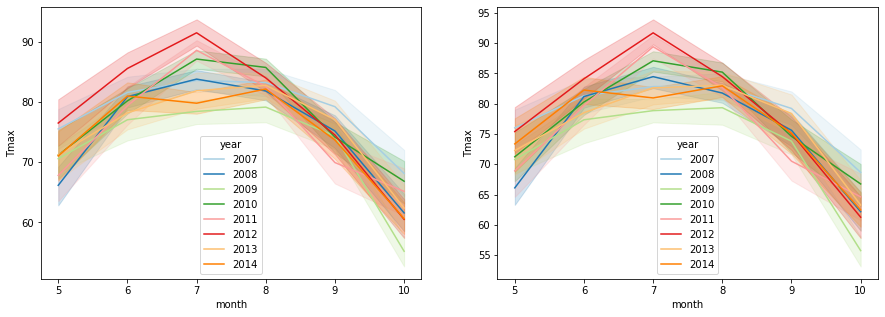

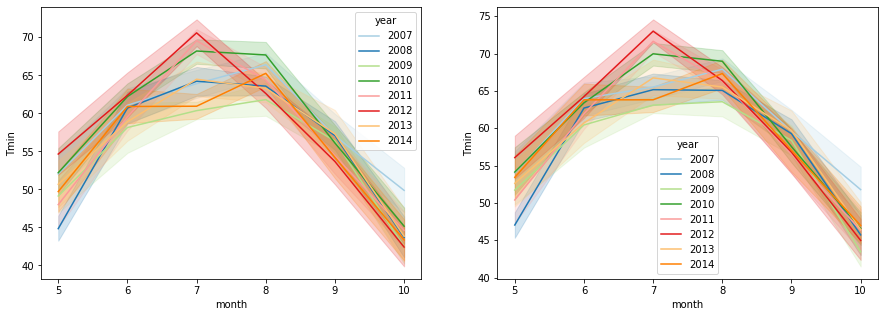

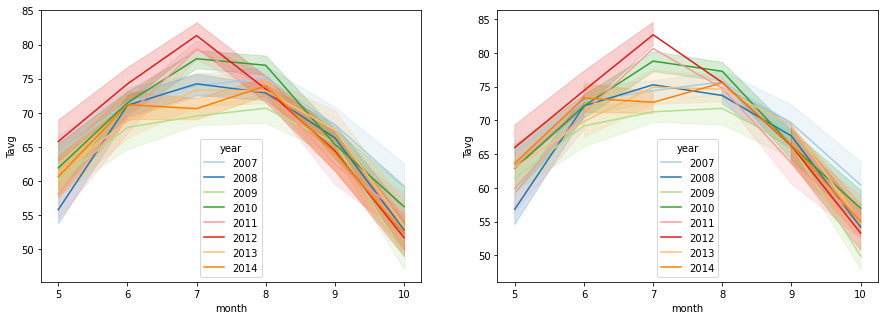

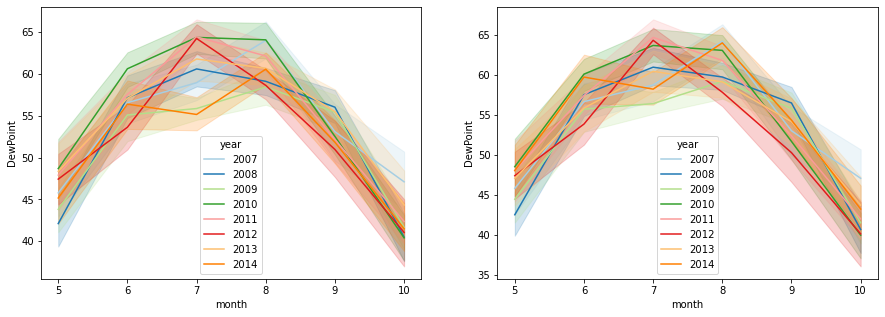

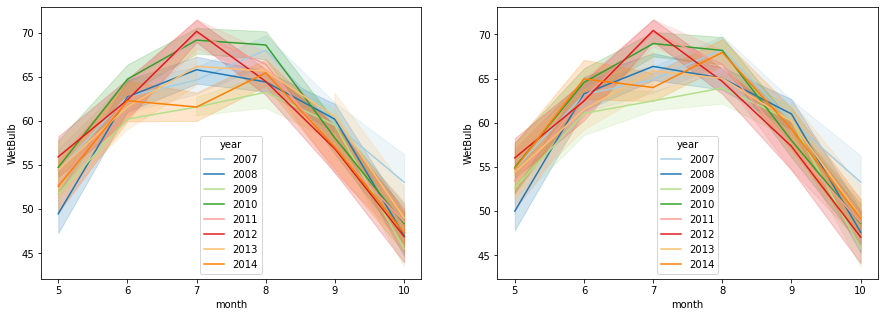

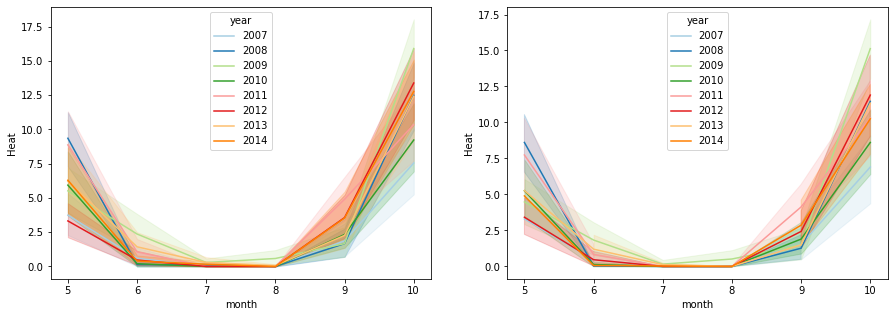

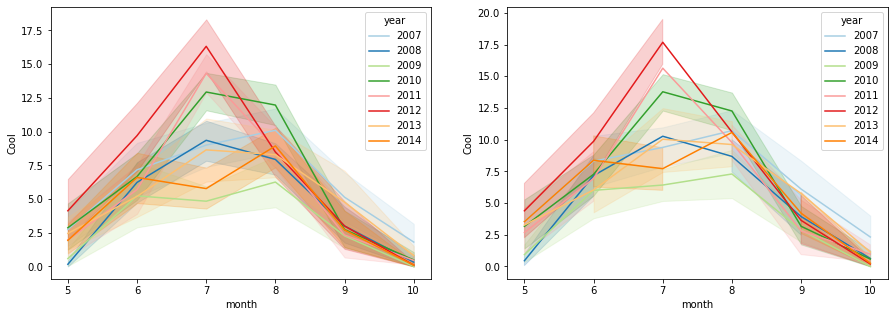

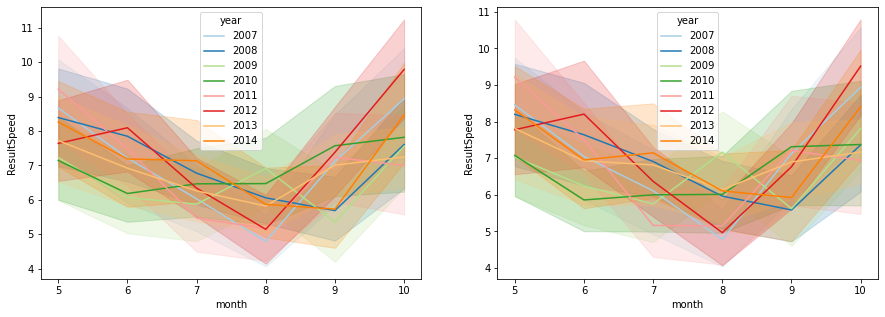

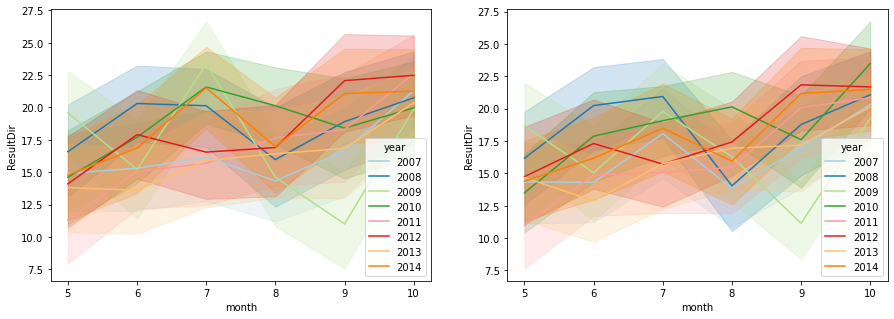

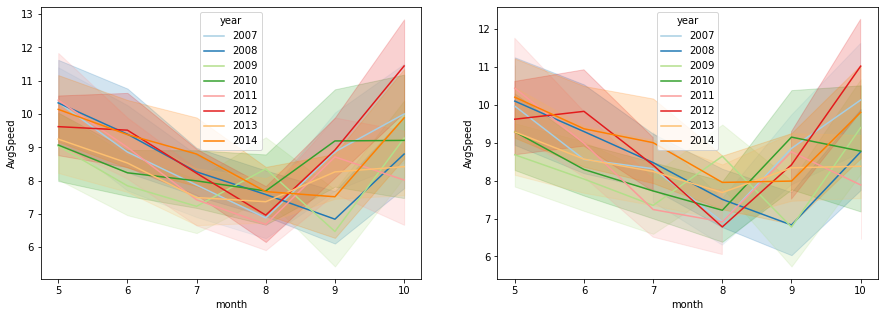

In [35]:
lineplot_list = [
                'Tmax', 
                'Tmin', 
                'Tavg', 
                'DewPoint', 
                'WetBulb', 
                'Heat', 
                'Cool',
                'ResultSpeed', 
                'ResultDir', 
                'AvgSpeed'
                ]

for i in lineplot_list:
    lineplotter(station1, station2, "month", i, "year")

In [36]:
# Averaging the values for PrecipTotal for station 1 and station 2

station1['PrecipTotal'] = (station1['PrecipTotal']+station2['PrecipTotal'])/2

<ipython-input-36-3f0a8b893e45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station1['PrecipTotal'] = (station1['PrecipTotal']+station2['PrecipTotal'])/2


In [37]:
# selecting station1 as weather dataset after imputing averaged PrecipTotal

weather = station1

### Identifying Irrelevant Columns to Drop

In [38]:
# Creating another custom lineplotting function

def lineplotter2 (data, var1, var2, label):
    
    plt.figure(figsize=(15,5))
    
    if type(var1) == list:
        
        for i in var1:
            plt.plot(data[var2], data[i], label = i)
            plt.ylabel(i)
            plt.xlabel(var2)
            plt.title(label = label, fontsize=18)
            plt.legend()
            
    else:
        plt.plot(data[var2], data[var1], label = var1)
        plt.ylabel(var1)
        plt.xlabel(var2)
        plt.title(label = label, fontsize=18)
        plt.legend()
        
    plt.show();

#### tmax, tmin, tavg
- The three temperature features follow a similar trend. 
- It was decided to keep all three features, as the nuances between them would help the model train.

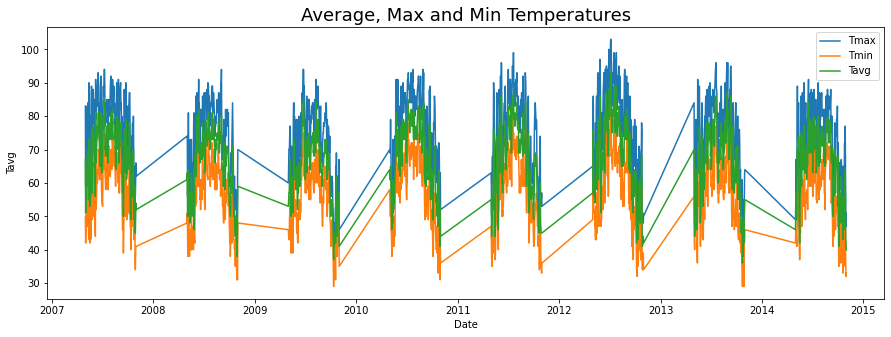

In [39]:
temp_list = ['Tmax', 'Tmin', 'Tavg']

lineplotter2(weather, temp_list, 'Date', 'Average, Max and Min Temperatures')

##### Depart, DewPoint, WetBulb, Heat, Cool, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed
- Based on the data dict, 'Depart' is the difference between the temperature of the day with its expected temperature.
- Dew point is the temperature to which air must be cooled to become saturated with water vapor.
- Wet bulb temperature is the lowest temperature to which air can be cooled by the evaporation of water into the air at a constant pressure.
- Dew point and Wet bulb are expected to give an indication of the humidity.
- Heat Cool and PrecipTotal appear to display a seasonal heat pattern throughout the years.
- StnPressure and SeaLevel are observed to show similar trends.
- ResultSpeed and AvgSpeed are observed to show similar trends.
- These features were kept in the event that they may contain useful data for the model to train upon.

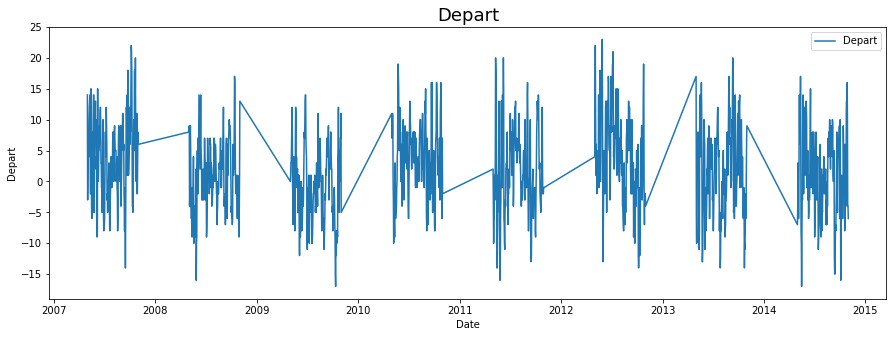

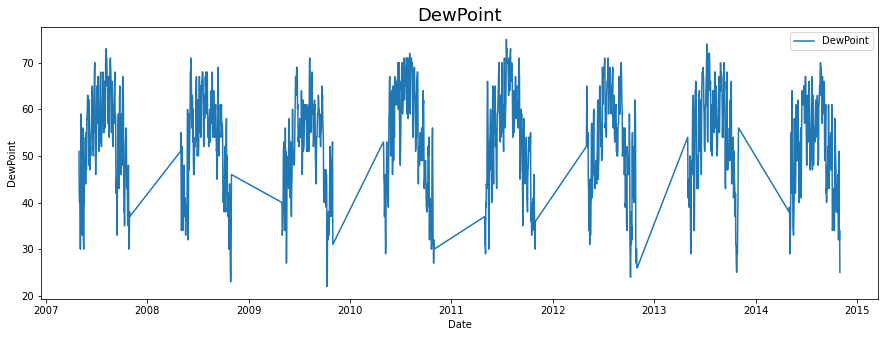

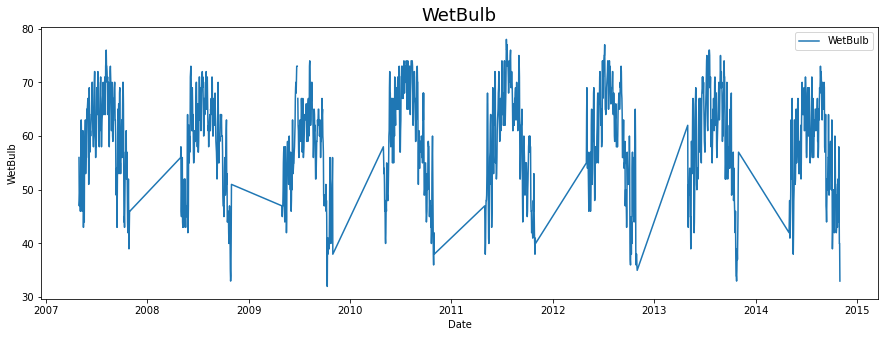

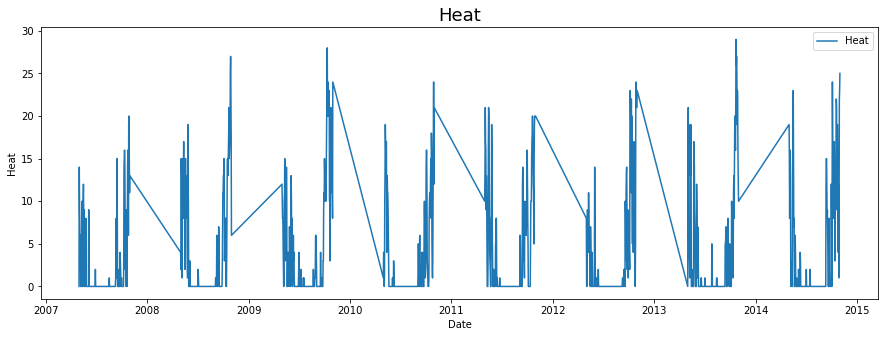

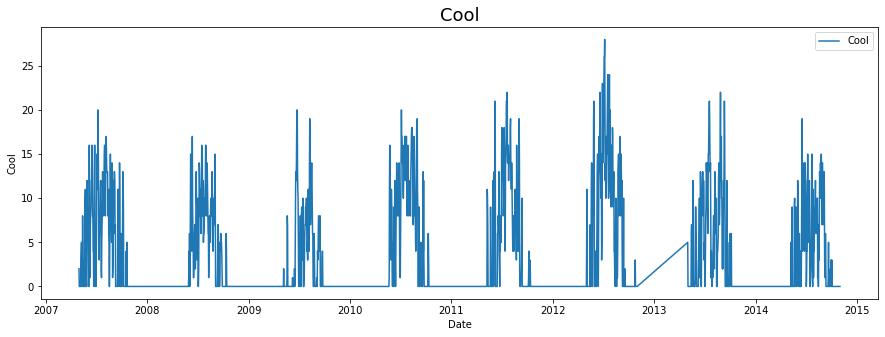

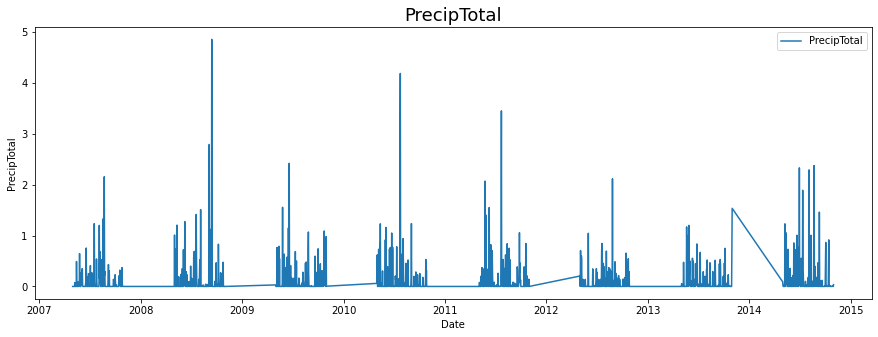

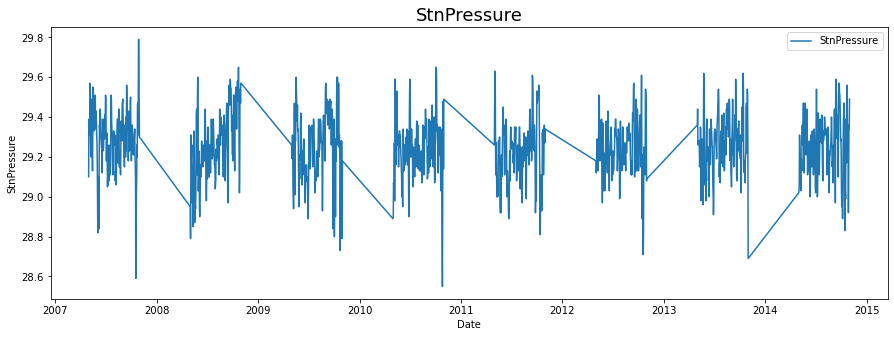

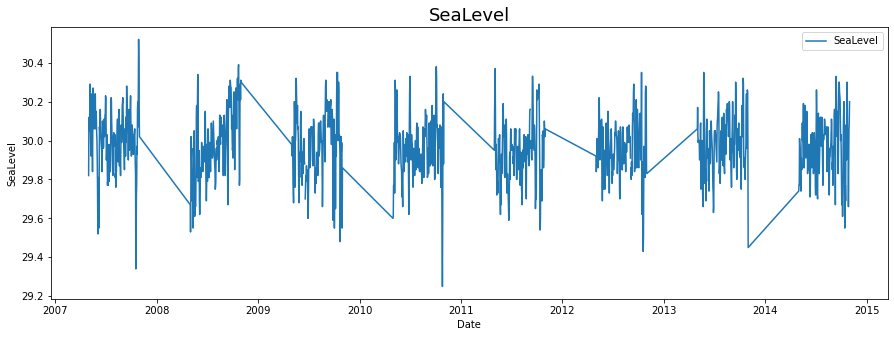

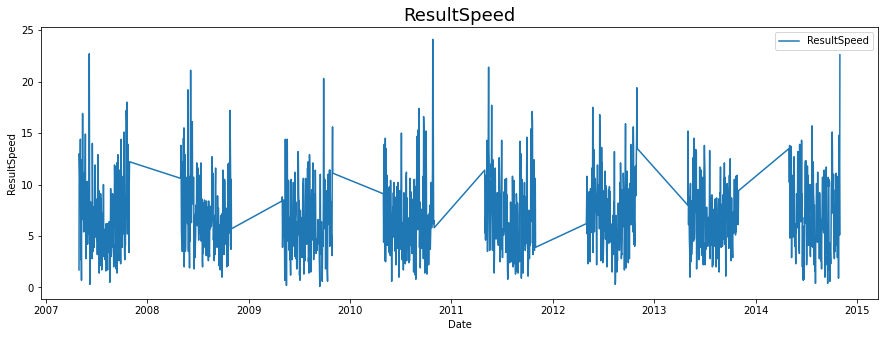

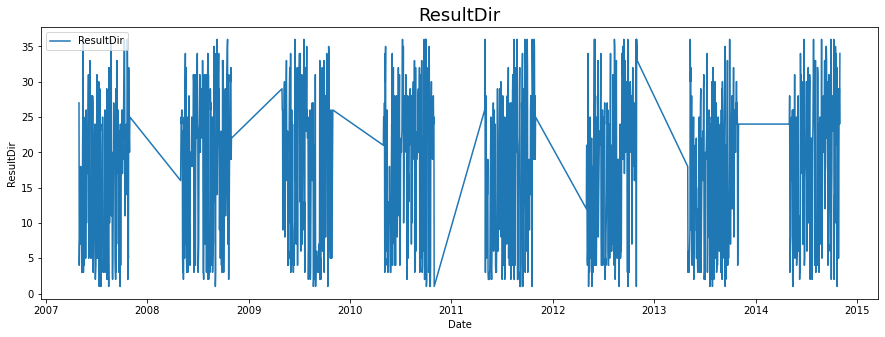

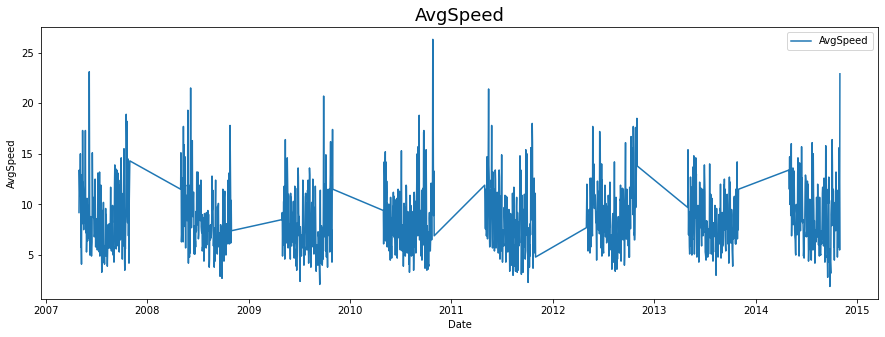

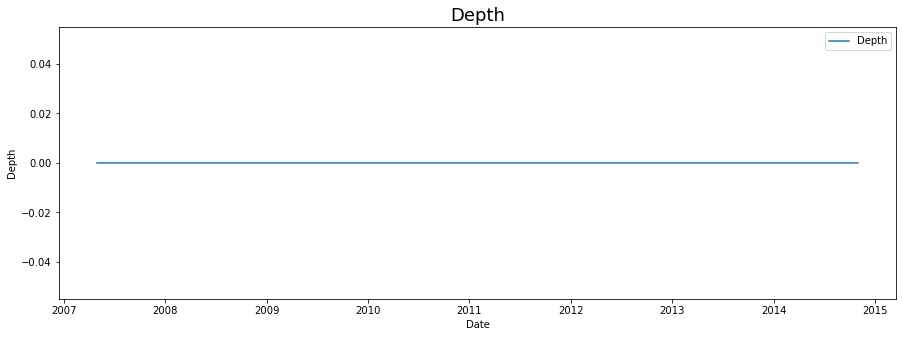

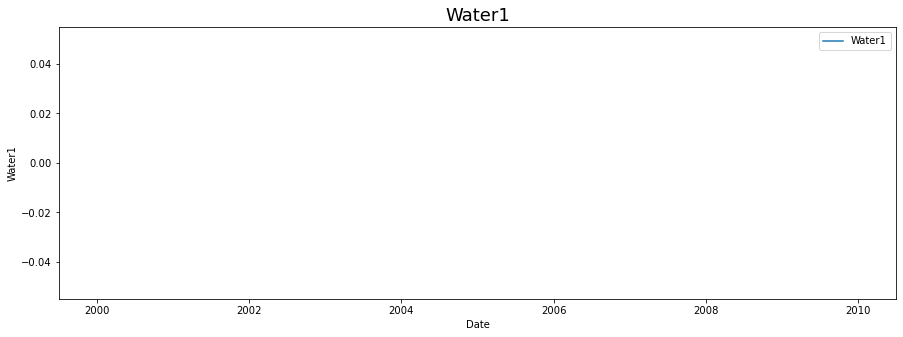

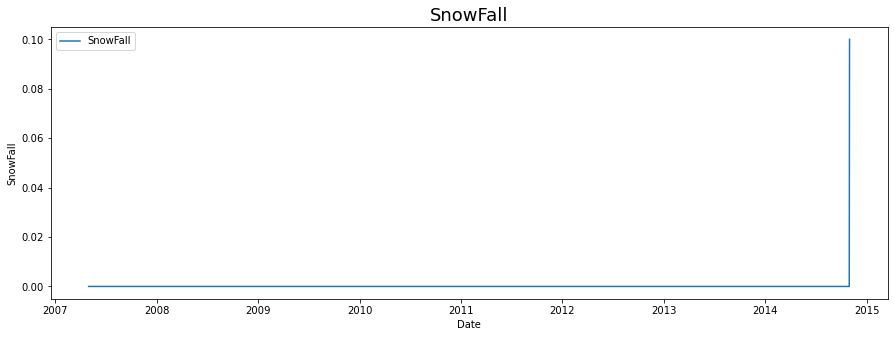

In [40]:
w_list = [
            'Depart', 
            'DewPoint', 
            'WetBulb', 
            'Heat', 
            'Cool', 
            'PrecipTotal', 
            'StnPressure', 
            'SeaLevel', 
            'ResultSpeed', 
            'ResultDir', 
            'AvgSpeed', 
            'Depth', 
            'Water1', 
            'SnowFall'
        ]

for i in w_list:
    lineplotter2(weather, i, 'Date', (str(i)))

##### Depth, Water1, SnowFall
- Depth, Water1, SnowFall have no records/noticeable trends and are thus selected for dropping

In [41]:
# Dropping the additional month/year columns that were created for visualization purposes & the selected features
weather.drop(columns = ['Station', 'Depth','Water1', 'SnowFall', 'month', 'year'], inplace = True)

In [42]:
weather.reset_index(drop = True, inplace = True)

In [43]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,0448,1849,,0.0,29.10,29.82,1.7,27.0,9.2
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,0447,1850,BR,0.0,29.38,30.09,13.0,4.0,13.4
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,0446,1851,,0.0,29.39,30.12,11.7,7.0,11.9
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,0444,1852,RA,0.0,29.31,30.05,10.4,8.0,10.8
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,0443,1853,,0.0,29.40,30.10,11.7,7.0,12.0


In [44]:
weather.shape

(1472, 18)

## Feature Engineering
[top](#Contents)

### Splitting the different weather types in CodeSum to individual columns

- We realized that we could use a CountVectorizer as a method of one-hot-encoding the codesum column
- The encoded "codesum" columns were subsequently combined back into the weather column

In [45]:
cvec = CountVectorizer(lowercase = False)

In [46]:
X = cvec.fit_transform(weather['CodeSum'])

In [47]:
CodeSum = pd.DataFrame(X.toarray(), 
                       columns=cvec.get_feature_names())
CodeSum.head()

,BCFG,BR,DZ,FG,FU,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCTS
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
CodeSum.shape

(1472, 13)

In [49]:
# Joining the vectorized weather types from CodeSum back to the main weather dataset
weather_combined = pd.concat([weather, CodeSum], axis = 1)

In [50]:
# Dropping the codesum column
weather_combined.drop(columns = ['CodeSum'], inplace = True)

In [51]:
weather_combined.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,FG,FU,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCTS
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,0448,...,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,0447,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,0446,...,0,0,0,0,0,0,0,0,0,0
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,0444,...,0,0,0,0,1,0,0,0,0,0
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,0443,...,0,0,0,0,0,0,0,0,0,0


### Creating Daylight Mins

- We realized that Sunrise and Sunset could be combined into a single column showing amount of daylight in number of minutes
- The "daylight_mins" column was added to the dataset and the sunrise and sunset columns dropped

In [52]:
def minute_converter(time):
    return (int(time[0:2])*60 + int(time[2:4]))

In [53]:
weather_combined['Daylight_Mins'] = weather_combined['Sunset'].apply(minute_converter) - weather_combined['Sunrise'].apply(minute_converter)

In [54]:
weather_combined['Daylight_Mins']

0       841
1       843
2       845
3       848
4       850
       ... 
1467    635
1468    632
1469    630
1470    627
1471    624
Name: Daylight_Mins, Length: 1472, dtype: int64

In [55]:
weather_combined[['Sunrise', 'Sunset', 'Daylight_Mins']]

,Sunrise,Sunset,Daylight_Mins
0,0448,1849,841
1,0447,1850,843
2,0446,1851,845
3,0444,1852,848
4,0443,1853,850
...,...,...,...
1467,0618,1653,635
1468,0619,1651,632
1469,0620,1650,630
1470,0622,1649,627


In [56]:
# dropping the sunrise and sunset column
weather_combined.drop(columns = ['Sunrise', 'Sunset'], inplace = True)

### Imputing values for null entries

- A quick check for null entries showed that there were several null entries in the "Wetbulb", "PrecipTotal", "StnPressure" and "SeaLevel" columns
- These null values are handled below

In [57]:
#checking for null entries
weather_combined.isnull().sum()

Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          3
Heat             0
Cool             0
PrecipTotal      2
StnPressure      2
SeaLevel         5
ResultSpeed      0
ResultDir        0
AvgSpeed         0
BCFG             0
BR               0
DZ               0
FG               0
FU               0
HZ               0
MIFG             0
RA               0
SN               0
SQ               0
TS               0
TSRA             0
VCTS             0
Daylight_Mins    0
dtype: int64

#### Imputing Wetbulb Temperature 

- As both the average daily temperature and dewpoint temperature are available, a <a href = "https://theweatherprediction.com/habyhints/170/ ">formula</a> for a quick estimate for wetbulb tempreature was used for imputation of values

In [58]:
for i in weather_combined.loc[weather_combined['WetBulb'].isnull()].index:
    weather_combined['WetBulb'][i] = weather_combined['Tavg'][i] - ((weather_combined['Tavg'][i] - weather_combined['DewPoint'][i])/3)

<ipython-input-58-e7b7b5d1e004>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_combined['WetBulb'][i] = weather_combined['Tavg'][i] - ((weather_combined['Tavg'][i] - weather_combined['DewPoint'][i])/3)


#### Imputing values for PrecipTotal, StnPressure, SeaLevel

- There are very few null values for the PrecipTotal, StnPressure and SeaLevel columns
- The variance of these columns were all small.
- Based on the above, we decided to use mean imputation to full up the null values

In [59]:
weather_combined['PrecipTotal'].describe()

count    1470.000000
mean        0.131418
std         0.358737
min         0.000000
25%         0.000000
50%         0.000000
75%         0.080000
max         4.855000
Name: PrecipTotal, dtype: float64

In [60]:
weather_combined['StnPressure'].describe()

count    1470.000000
mean       29.254204
std         0.156147
min        28.550000
25%        29.160000
50%        29.260000
75%        29.350000
max        29.790000
Name: StnPressure, dtype: float64

In [61]:
weather_combined['SeaLevel'].describe()

count    1467.000000
mean       29.972802
std         0.158202
min        29.250000
25%        29.880000
50%        29.980000
75%        30.070000
max        30.520000
Name: SeaLevel, dtype: float64

In [62]:
for col in ['PrecipTotal', 'SeaLevel', 'StnPressure']:
    weather_combined[col].fillna(weather_combined[col].mean(), inplace=True)

### Agggregating Weather Features with a 7 & 14 day moving average

- A rolling function was used to aggregate the weather features with a 7 & 14 day moving average
- 7 and 14 day averages were chosen as they coincide with the life cycle stages of mosquitos

In [63]:
# defining rollers

rollers = [i for i in weather_combined.columns if i != 'Date']

In [64]:
# function to roll columns

def roller(df, col, no_days):
    name = col + "_" + str(no_days)
    df[[name]] = df[[col]].rolling(no_days).mean()

In [65]:
# selecting number of days to roll

num_days = [7, 14]

for num in num_days:
    for i in rollers:
        roller(weather_combined, i, num)

In [66]:
weather_combined.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,...,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
weather_combined.shape

(1472, 85)

## Prep for EDA
[top](#Contents)

### Removing all null rows

- The rolling function created some null rows. These rows were dropped.

In [68]:
weather_combined.isnull().sum()

Date                 0
Tmax                 0
Tmin                 0
Tavg                 0
Depart               0
                    ..
SQ_14               13
TS_14               13
TSRA_14             13
VCTS_14             13
Daylight_Mins_14    13
Length: 85, dtype: int64

In [69]:
weather_combined.dropna(inplace = True)

### Setting Date as index

In [70]:
weather_combined.set_index('Date', inplace = True)

In [71]:
weather_combined.head()

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,...,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-14,90,56,73.0,15.0,47,59.0,0.0,8.0,0.000,29.23,...,0.0,0.071429,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,855.928571
2007-05-15,80,57,69.0,11.0,56,61.0,0.0,4.0,0.490,29.13,...,0.0,0.071429,0.0,0.214286,0.0,0.0,0.0,0.0,0.0,858.142857
2007-05-16,66,44,55.0,-4.0,43,48.0,10.0,0.0,0.105,29.33,...,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,860.357143
2007-05-17,62,43,53.0,-6.0,32,43.0,12.0,0.0,0.000,29.55,...,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,862.571429
2007-05-18,71,42,57.0,-3.0,30,46.0,8.0,0.0,0.000,29.53,...,0.0,0.071429,0.0,0.214286,0.0,0.0,0.0,0.0,0.0,864.714286


### Merging Weather and Train Dataset

In [72]:
combined_df = pd.merge(train_new, weather_combined, on=['Date'], how='inner')

In [73]:
combined_df.head()

,Date,Trap,Latitude,Longitude,Species,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,...,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14
0,2007-05-29,T002,41.954690,-87.800991,CULEX PIPIENS/RESTUANS,1,0,88,60,74.0,...,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429
1,2007-05-29,T002,41.954690,-87.800991,CULEX RESTUANS,1,0,88,60,74.0,...,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429
2,2007-05-29,T007,41.994991,-87.769279,CULEX RESTUANS,1,0,88,60,74.0,...,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429
3,2007-05-29,T015,41.974089,-87.824812,CULEX PIPIENS/RESTUANS,1,0,88,60,74.0,...,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429
4,2007-05-29,T015,41.974089,-87.824812,CULEX RESTUANS,4,0,88,60,74.0,...,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429


In [74]:
combined_df.shape

(8475, 91)

## EDA

[top](#Contents)

### Relationship between WNV and mosquitoes

#### WNV by Species
- Only three species of mosquitoes were found to carry WNV

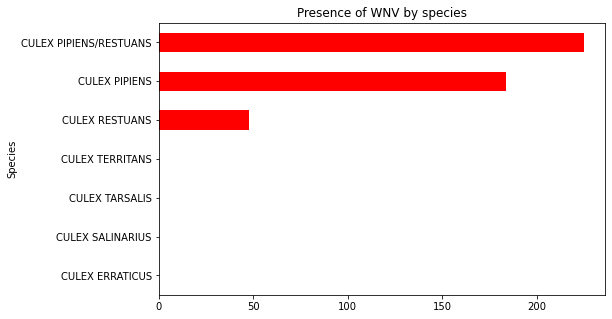

In [75]:
plt.figure(figsize=(8,5))
combined_df.groupby('Species')['WnvPresent'].sum().sort_values().plot(kind='barh', color='red')
plt.title('Presence of WNV by species');

#### Locations where WNV was found by Spray and Trap locations by Year and Month
- Other than the month of Aug 2013, minimal spraying was done based on the given data.

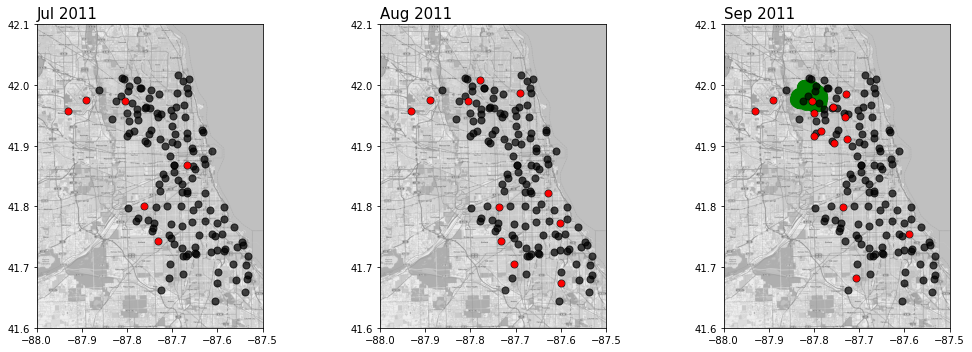

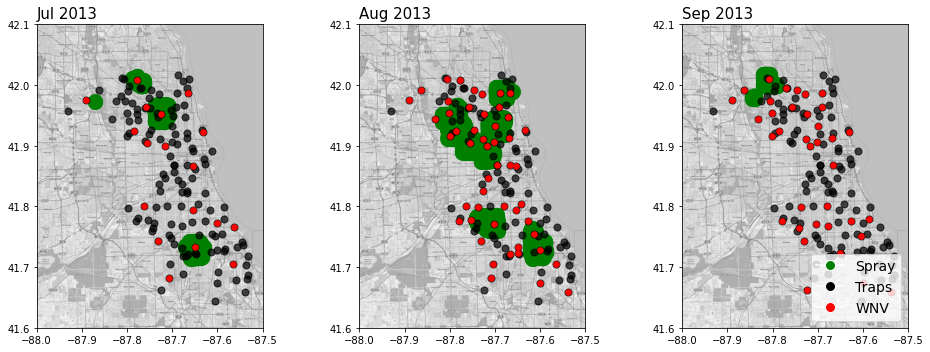

In [76]:
# plot of spray and WNV infections over the years

# loading basemap
mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# creating subplots for each month and year that spraying was performed
for year in spray.Date.dt.year.unique():
    fig, ax = plt.subplots(ncols = 3, figsize = (16,5))
    
    for i, month in enumerate([7,8,9]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        
        if year in spray.Date.dt.year.unique() and month in spray.Date.dt.month.unique():
            
            # plot spray locations for year and month
            sprayed = spray[(spray.Date.dt.year == year) & 
                               (spray.Date.dt.month == month) &
                               (spray.Longitude>-88) &
                               (spray.Longitude<-87.5) &
                               (spray.Latitude>41.6) &
                               (spray.Latitude<42.1)][['Longitude', 'Latitude']].drop_duplicates().values
            
            ax[i].scatter(sprayed[:,0], sprayed[:,1],  marker='o', c = 'green', s = 200, alpha = 0.5)
            
            
            # consolidating date/time and locations of WNV
            wnv = combined_df[(combined_df.Date.dt.year == year) & (combined_df.Date.dt.month == month) & (combined_df.WnvPresent == 1)]\
                [['Longitude', 'Latitude']].drop_duplicates().values
        

            # plot trap locations
            locations = combined_df[['Longitude', 'Latitude']].drop_duplicates().values
            ax[i].scatter(locations[:,0], locations[:,1], marker='o', c = 'black', s=50, alpha = 0.7)

            # plot locations of WNV found
            ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'red', s = 30)        
      
          
            # title and axes
            do = datetime.strptime(str(month), "%m")
            month_name = do.strftime("%b")

            ax[i].set_title(f"{month_name} {year}", fontsize = 15, ha = 'left', position = (0,1))


            plt.tight_layout()

# legend
legend_elements=[Line2D([0],[0],marker='o', color='white',label='Spray', markerfacecolor='green', markersize=10),
                 Line2D([0],[0],marker='o', color='white', label='Traps',markerfacecolor='black', markersize=10),
                 Line2D([0],[0],marker='o', color='white',label='WNV',markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.tight_layout()

#### No. of Mosquitoes caught by day, month and year
- No observable trend in terms of the day the mosquitoes are caught.
- Month-wise the number of mosquitoes start increasing from May before dipping after August.
- Year-wise, a larger number of mosquitoes were observed at the start and end of the period of data collection for the train dataset.

In [77]:
# Converting year, month and day columsn to datetime for further EDA

combined_df['year'], combined_df['month'], combined_df['day'] = combined_df['Date'].dt.year, combined_df['Date'].dt.month,combined_df['Date'].dt.day

In [78]:
# custom histogram plotting function

def subplot_histograms(dataframe, yvar, list_of_xvars, list_of_titles, list_of_xlabels, ylabel):
    
    # Creating subplots
    
    nrows = int(np.ceil(len(list_of_xvars)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,10)) 
    ax = ax.ravel() 
    
    # plotting based on list of x variables
    
    for i, column in enumerate(list_of_xvars):
        dataframe.groupby(column)[yvar].mean().plot(kind='bar', ax=ax[i])
        ax[i].set_title(list_of_titles[i])
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(ylabel)
    plt.tight_layout()

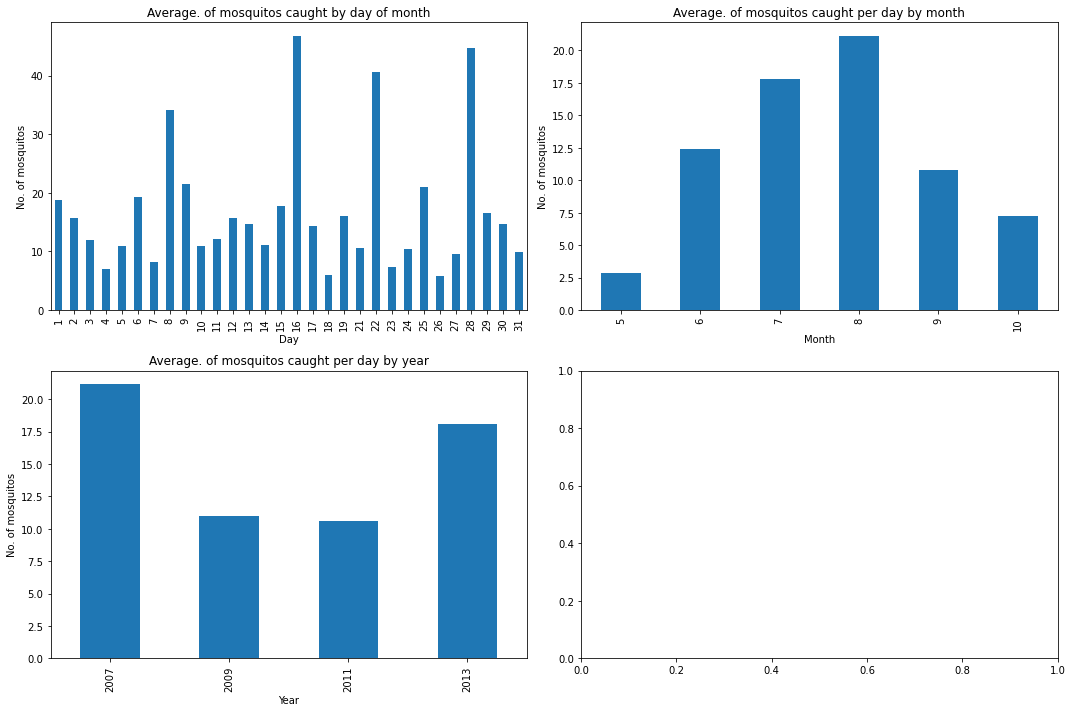

In [79]:
subplot_histograms(dataframe=combined_df,
                   yvar ='NumMosquitos',
                  list_of_xvars=['day','month', 'year'],
                  list_of_titles=['Average. of mosquitos caught by day of month',
                                  'Average. of mosquitos caught per day by month', 
                                  'Average. of mosquitos caught per day by year'],
                  list_of_xlabels=['Day','Month', 'Year'],
                  ylabel='No. of mosquitos')

#### Presence of WNV by day, month and year
- Similar trends to the number of mosquitoes (with or without WNV) observed above. This makes sense since the spread of the virus is expected to be linked to the mosquito population

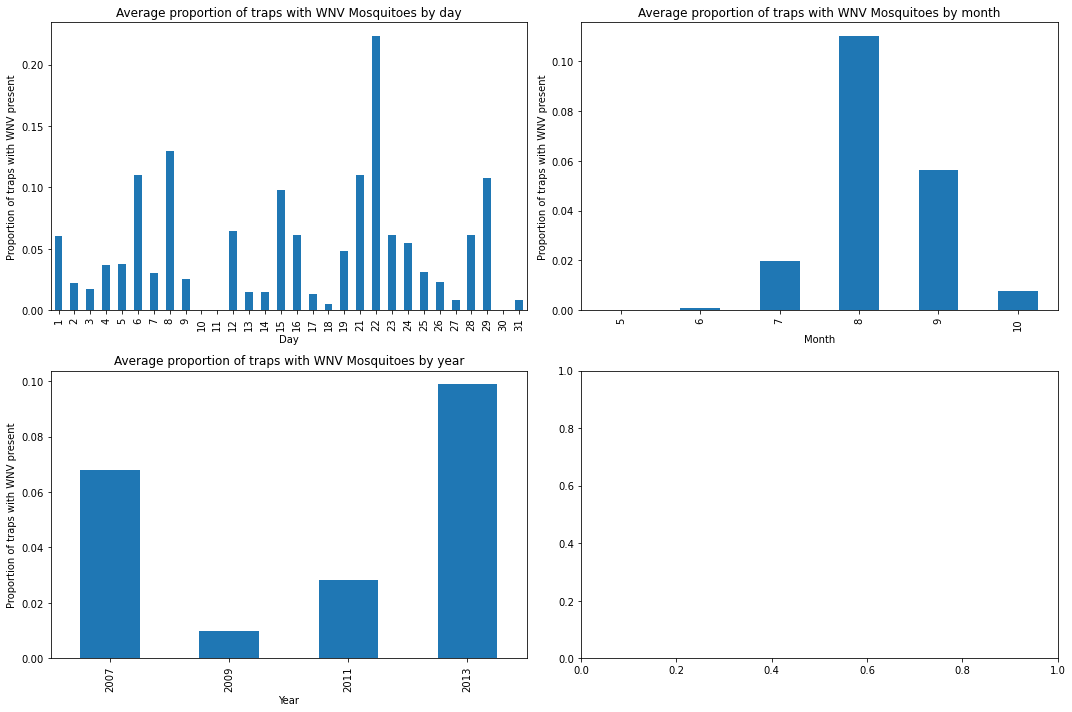

In [80]:
subplot_histograms(dataframe=combined_df,
                   yvar ='WnvPresent',
                   list_of_xvars=['day' ,'month', 'year'],
                   list_of_titles=['Average proportion of traps with WNV Mosquitoes by day', 'Average proportion of traps with WNV Mosquitoes by month', 'Average proportion of traps with WNV Mosquitoes by year'],
                   list_of_xlabels=['Day', 'Month', 'Year'],
                   ylabel='Proportion of traps with WNV present')

#### Investigating Number of WNV Mosquitoes after spray dates
- Aug 2013 is selected for a more detailed analysis since it was the month with the most extensive spraying within the dataset

In [81]:
# extracting august (month 8) into a separate dataframe

aug_df = combined_df[(combined_df.Date.dt.year == 2013) & (combined_df.Date.dt.month == 8)]
aug_df.set_index('Date', inplace = True)

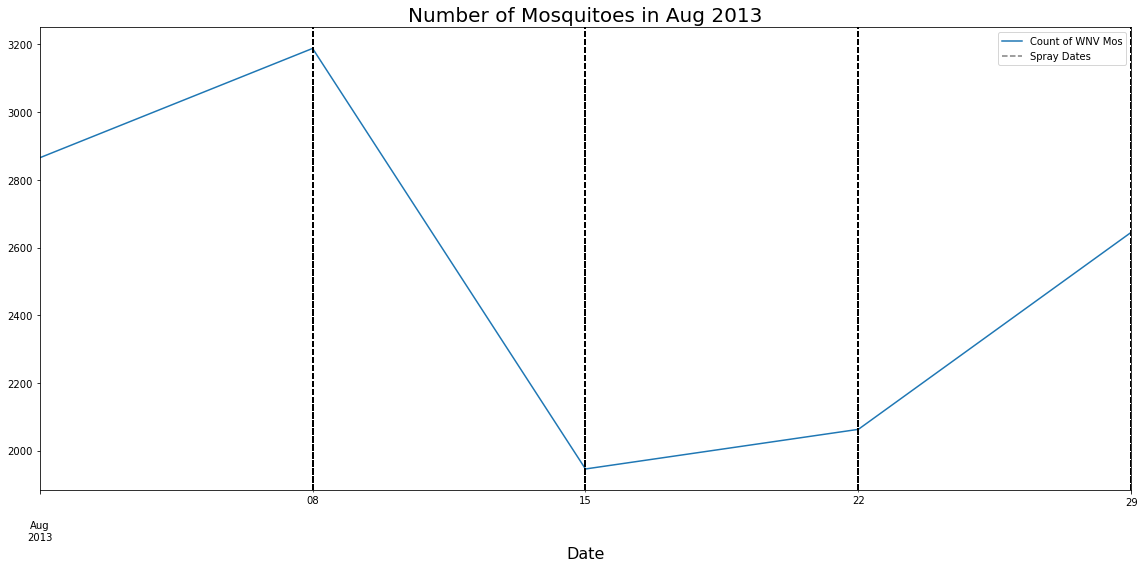

In [84]:
spray_aug = spray[(spray.Date.dt.year == 2013) & (spray.Date.dt.month == 8)]
aug_df.groupby('Date')['NumMosquitos'].sum().plot(figsize=(16,8))

# creating vertical lines for spray dates
for date in spray_aug['Date']:
    plt.axvline(date, linestyle='--', color='black', alpha=0.5, label="Spray Dates")

plt.legend([f'Count of WNV Mos', 'Spray Dates'], loc = 'upper right')
plt.title(f'Number of Mosquitoes in Aug 2013', fontsize = 20)
plt.xlabel("Date", fontsize = 16)
plt.tight_layout()

### Analysis of Weather and Virus

#### No. of WNV carrying Mosquito caught by Temperature
- Plots below indicate that mosquitoes, and as a result the virus, tend to spread during the warmer season

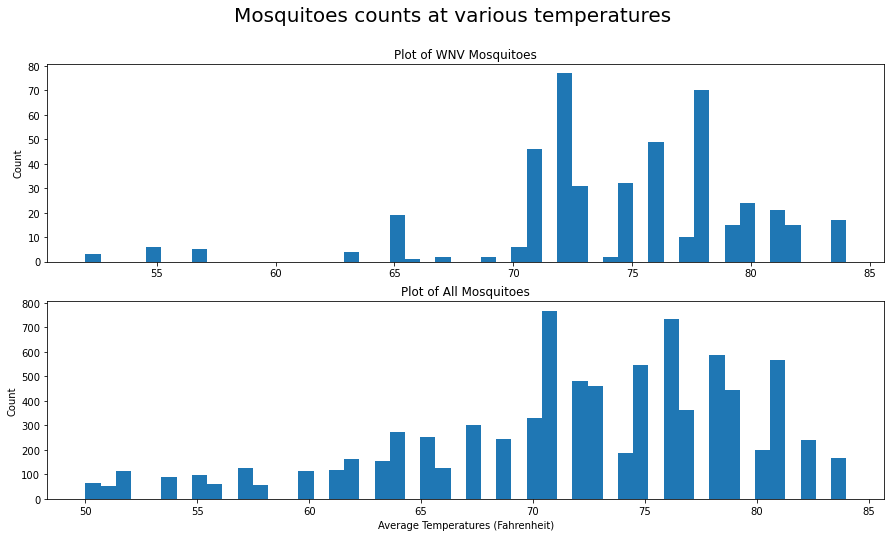

In [85]:
wnv = combined_df[combined_df['WnvPresent'] == True]['Tavg'].tolist()
temp = combined_df['Tavg'].tolist()

# creating subplots
fig, axs = plt.subplots(2,figsize=(15,8))
fig.suptitle('Mosquitoes counts at various temperatures', fontsize=20)
axs[0].hist(wnv,bins=50)
axs[1].hist(temp,bins=50)
axs[0].title.set_text('Plot of WNV Mosquitoes')
axs[1].title.set_text('Plot of All Mosquitoes')
axs[0].set_ylabel('Count',fontsize=10)
axs[1].set_ylabel('Count',fontsize=10)
axs[1].set_xlabel('Average Temperatures (Fahrenheit)',fontsize=10)
plt.show()

#### Effect of AvgSpeed on Virus
- WnvPresent appear to be slightly linked to lower Average WindSpeeds. This does makes sense since higher windspeeds may make it difficult for small insects to fly around.

In [86]:
# Custom function to create boxplots

def boxplotter(data, x_val, y_val, hue_val):
    fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
    sns.boxplot(x = data[x_val], y = data[y_val].replace(np.NaN,0.0).apply(float), hue = data[hue_val], ax=ax1)
    ax1.set_title(y_val, fontdict= {'fontsize':15})
    plt.show()

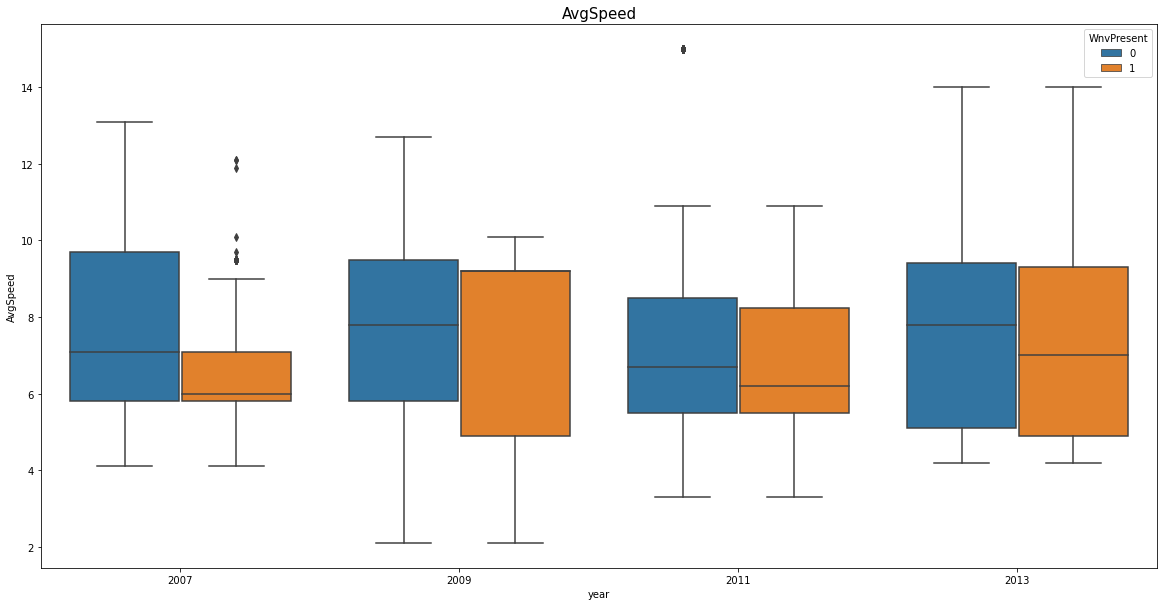

In [87]:
boxplotter(combined_df, "year", 'AvgSpeed', "WnvPresent")

#### Effect of WetBulb on Virus
- 2007 and 2009 data seem to suggest that higher wet bulb temperatures (and thus higher relative humidities) lead to a higher chance of WNV presence. However, this is not supported by the data in the subsequent years.

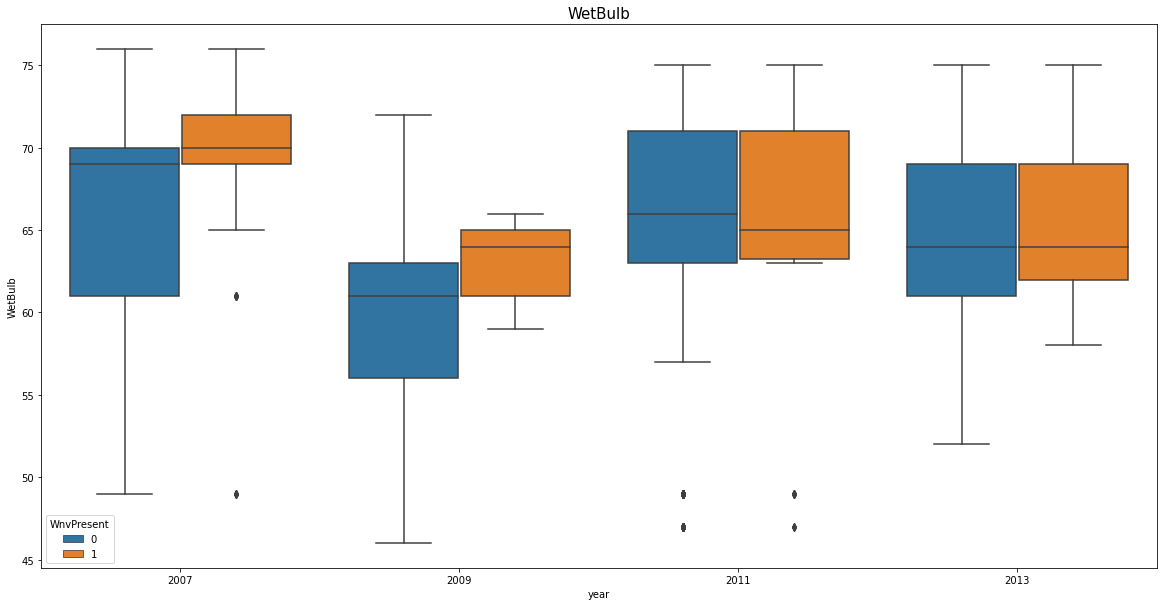

In [88]:
boxplotter(combined_df, "year", 'WetBulb', "WnvPresent")

##### Effect of PrecipTotal on Virus
- Boxplots for 2009 indicate that higher amounts of precipitation increase the chance of WNV presence which matches the general expectation that mosquitoes proliferate when it is wet. However, this is not supported by data from the subsequent years.

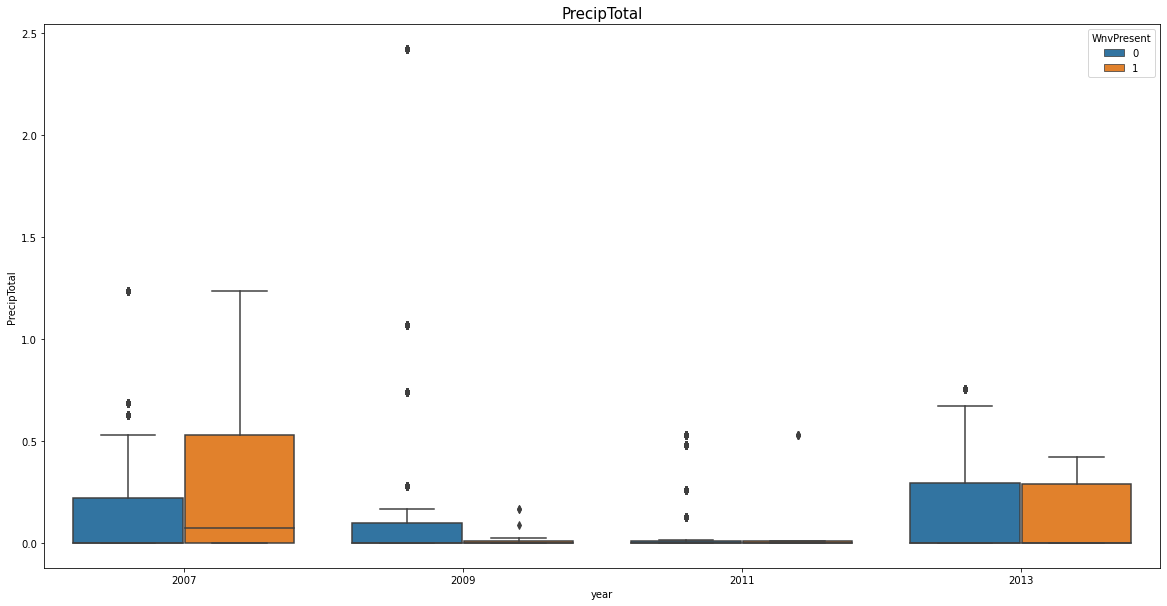

In [89]:
boxplotter(combined_df, "year", 'PrecipTotal', "WnvPresent")

##### Effect of Daylightmins on Virus
- Since the mosquitoes are active at night, more daylight hours are expected to reduce the chance of WNV presence. The plots below illustrate this.

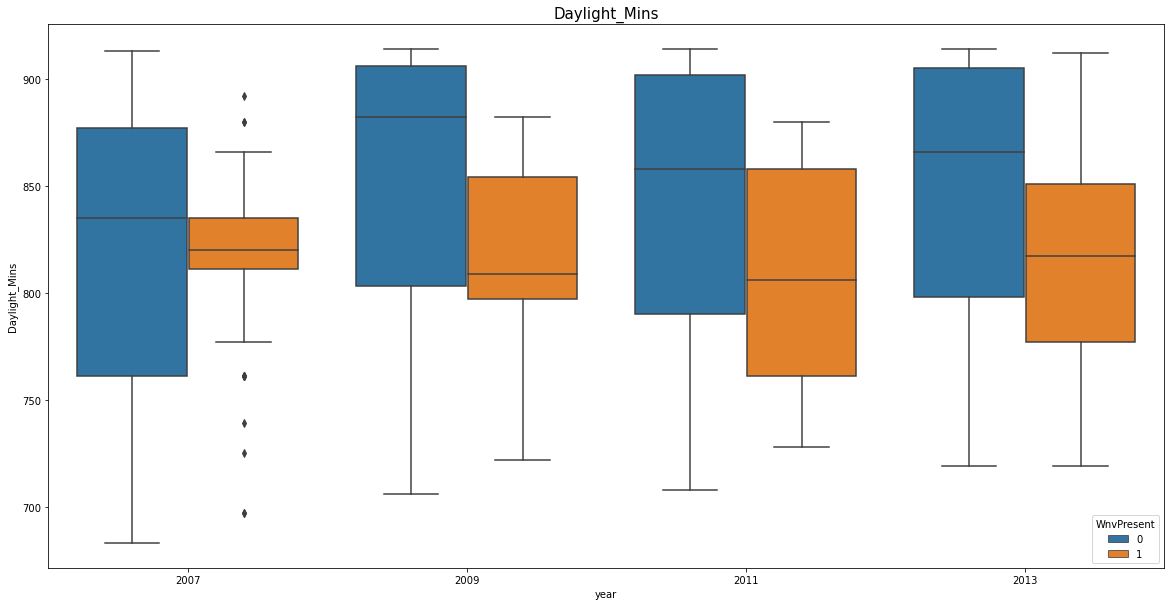

In [90]:
boxplotter(combined_df, "year", 'Daylight_Mins', "WnvPresent")

## Prep for Modelling

[top](#Contents)

### Train Dataset

#### Drop irrelevant columns

In [91]:
combined_df.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'BCFG', 'BR', 'DZ', 'FG', 'FU', 'HZ', 'MIFG',
       'RA', 'SN', 'SQ', 'TS', 'TSRA', 'VCTS', 'Daylight_Mins', 'Tmax_7',
       'Tmin_7', 'Tavg_7', 'Depart_7', 'DewPoint_7', 'WetBulb_7', 'Heat_7',
       'Cool_7', 'PrecipTotal_7', 'StnPressure_7', 'SeaLevel_7',
       'ResultSpeed_7', 'ResultDir_7', 'AvgSpeed_7', 'BCFG_7', 'BR_7', 'DZ_7',
       'FG_7', 'FU_7', 'HZ_7', 'MIFG_7', 'RA_7', 'SN_7', 'SQ_7', 'TS_7',
       'TSRA_7', 'VCTS_7', 'Daylight_Mins_7', 'Tmax_14', 'Tmin_14', 'Tavg_14',
       'Depart_14', 'DewPoint_14', 'WetBulb_14', 'Heat_14', 'Cool_14',
       'PrecipTotal_14', 'StnPressure_14', 'SeaLevel_14', 'ResultSpeed_14',
       'ResultDir_14', 'AvgSpeed_14', 'BCFG_14', 'BR_14', 'DZ_14', 'FG_14',
       'FU_14', 'HZ_

In [92]:
combined_df.drop(['Date', 'day', 'year', 'Trap'],axis=1,inplace=True)

- Traps are dropped since they are simply location IDs

#### One Hot Encoding Species

In [93]:
combined_df = pd.get_dummies(combined_df, columns=['Species'], drop_first=True)

#### One Hot Encoding Month

In [94]:
combined_df = pd.get_dummies(combined_df, columns=['month'], drop_first=False)

#### Drop num_mos in Train Dataset

In [95]:
combined_df.drop(columns = ['NumMosquitos'], inplace=True)

#### Drop species not at risk for carrying virus in Train Dataset

In [96]:
combined_df = combined_df.drop(columns=['Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'], axis=1)

#### Peek at Finalized Dataset

In [97]:
combined_df.head()

,Latitude,Longitude,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,...,Daylight_Mins_14,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,month_5,month_6,month_7,month_8,month_9,month_10
0,41.954690,-87.800991,0,88,60,74.0,10.0,58,65.0,0.0,...,886.071429,0,1,0,1,0,0,0,0,0
1,41.954690,-87.800991,0,88,60,74.0,10.0,58,65.0,0.0,...,886.071429,0,0,1,1,0,0,0,0,0
2,41.994991,-87.769279,0,88,60,74.0,10.0,58,65.0,0.0,...,886.071429,0,0,1,1,0,0,0,0,0
3,41.974089,-87.824812,0,88,60,74.0,10.0,58,65.0,0.0,...,886.071429,0,1,0,1,0,0,0,0,0
4,41.974089,-87.824812,0,88,60,74.0,10.0,58,65.0,0.0,...,886.071429,0,0,1,1,0,0,0,0,0


In [98]:
combined_df.shape

(8475, 96)

#### Test Dataset

- We imported the Test Dataset and did the same transformations that were performed on the Train Dataset

In [99]:
test = pd.read_csv('./data/test.csv')

In [100]:
test.drop(columns = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Id'], inplace = True)

In [101]:
test['Date'] = pd.to_datetime(test['Date'])

In [102]:
test_weather = pd.merge(test, weather_combined, on='Date', how='inner')

In [103]:
test_weather.shape

(116293, 89)

In [104]:
test_weather.isnull().sum()

Date                0
Species             0
Trap                0
Latitude            0
Longitude           0
                   ..
SQ_14               0
TS_14               0
TSRA_14             0
VCTS_14             0
Daylight_Mins_14    0
Length: 89, dtype: int64

In [105]:
test_weather['month'] = test_weather['Date'].dt.month

In [106]:
test_weather.drop(['Date', 'Trap'],axis=1,inplace=True)

In [107]:
test_weather = pd.get_dummies(test_weather,columns=['Species'],drop_first=False)

In [108]:
test_weather = pd.get_dummies(test_weather, columns=['month'], drop_first=False)

#### Checking for data that is present in one set but not in the other and correcting the datasets accordingly

In [109]:
# These are weather types that the test dataset do not have
train_list=[]
for i in combined_df.columns:
    if i not in test_weather and i != 'WnvPresent':
        train_list.append(i)
        
train_list

['month_5']

In [110]:
# Adding May month to the test dataset as a column of "0"
test_weather["month_5"] = 0

In [111]:
# These are features that the combined_df do not have.
test_list=[]
for i in test_weather.columns:
    if i not in combined_df: # and i != 'WnvPresent':
        test_list.append(i)
        
test_list

['Species_CULEX ERRATICUS',
 'Species_CULEX SALINARIUS',
 'Species_CULEX TARSALIS',
 'Species_CULEX TERRITANS',
 'Species_UNSPECIFIED CULEX']

In [112]:
# Drop these columns from test
cols_to_drop = ['Species_CULEX ERRATICUS',
 'Species_CULEX SALINARIUS',
 'Species_CULEX TARSALIS',
 'Species_CULEX TERRITANS',
 'Species_UNSPECIFIED CULEX']
test_weather = test_weather.drop(cols_to_drop, axis=1)

- Checked that number of columns for the test dataset is less than the train dataset by 1 since it does not contain the target variable

In [113]:
len(combined_df.columns)

96

In [114]:
len(test_weather.columns)

95

#### Re-ordering columns

In [115]:
combined_df.columns

Index(['Latitude', 'Longitude', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BCFG', 'BR', 'DZ',
       'FG', 'FU', 'HZ', 'MIFG', 'RA', 'SN', 'SQ', 'TS', 'TSRA', 'VCTS',
       'Daylight_Mins', 'Tmax_7', 'Tmin_7', 'Tavg_7', 'Depart_7', 'DewPoint_7',
       'WetBulb_7', 'Heat_7', 'Cool_7', 'PrecipTotal_7', 'StnPressure_7',
       'SeaLevel_7', 'ResultSpeed_7', 'ResultDir_7', 'AvgSpeed_7', 'BCFG_7',
       'BR_7', 'DZ_7', 'FG_7', 'FU_7', 'HZ_7', 'MIFG_7', 'RA_7', 'SN_7',
       'SQ_7', 'TS_7', 'TSRA_7', 'VCTS_7', 'Daylight_Mins_7', 'Tmax_14',
       'Tmin_14', 'Tavg_14', 'Depart_14', 'DewPoint_14', 'WetBulb_14',
       'Heat_14', 'Cool_14', 'PrecipTotal_14', 'StnPressure_14', 'SeaLevel_14',
       'ResultSpeed_14', 'ResultDir_14', 'AvgSpeed_14', 'BCFG_14', 'BR_14',
       'DZ_14', 'FG_14', 'FU_14', 'HZ_14', 'MIFG_14', 'RA_14', 'SN_14',
       'SQ_14', 

In [116]:
test_weather.columns

Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BCFG', 'BR', 'DZ', 'FG', 'FU',
       'HZ', 'MIFG', 'RA', 'SN', 'SQ', 'TS', 'TSRA', 'VCTS', 'Daylight_Mins',
       'Tmax_7', 'Tmin_7', 'Tavg_7', 'Depart_7', 'DewPoint_7', 'WetBulb_7',
       'Heat_7', 'Cool_7', 'PrecipTotal_7', 'StnPressure_7', 'SeaLevel_7',
       'ResultSpeed_7', 'ResultDir_7', 'AvgSpeed_7', 'BCFG_7', 'BR_7', 'DZ_7',
       'FG_7', 'FU_7', 'HZ_7', 'MIFG_7', 'RA_7', 'SN_7', 'SQ_7', 'TS_7',
       'TSRA_7', 'VCTS_7', 'Daylight_Mins_7', 'Tmax_14', 'Tmin_14', 'Tavg_14',
       'Depart_14', 'DewPoint_14', 'WetBulb_14', 'Heat_14', 'Cool_14',
       'PrecipTotal_14', 'StnPressure_14', 'SeaLevel_14', 'ResultSpeed_14',
       'ResultDir_14', 'AvgSpeed_14', 'BCFG_14', 'BR_14', 'DZ_14', 'FG_14',
       'FU_14', 'HZ_14', 'MIFG_14', 'RA_14', 'SN_14', 'SQ_14', 'TS_14',
       'TSRA

In [117]:
# Creating a list of features to reorder datasets

features_list = combined_df.columns.tolist()
features_list.remove("WnvPresent")

In [118]:
# Reordering combined_df

combined_df = combined_df[(features_list + ["WnvPresent"])]

In [119]:
# Reordering test_weather

test_weather = test_weather[features_list]

### Export for Modelling

In [120]:
pd.set_option('display.max_columns', None)
combined_df.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,BCFG,BR,DZ,FG,FU,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCTS,Daylight_Mins,Tmax_7,Tmin_7,Tavg_7,Depart_7,DewPoint_7,WetBulb_7,Heat_7,Cool_7,PrecipTotal_7,StnPressure_7,SeaLevel_7,ResultSpeed_7,ResultDir_7,AvgSpeed_7,BCFG_7,BR_7,DZ_7,FG_7,FU_7,HZ_7,MIFG_7,RA_7,SN_7,SQ_7,TS_7,TSRA_7,VCTS_7,Daylight_Mins_7,Tmax_14,Tmin_14,Tavg_14,Depart_14,DewPoint_14,WetBulb_14,Heat_14,Cool_14,PrecipTotal_14,StnPressure_14,SeaLevel_14,ResultSpeed_14,ResultDir_14,AvgSpeed_14,BCFG_14,BR_14,DZ_14,FG_14,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,month_5,month_6,month_7,month_8,month_9,month_10,WnvPresent
0,41.954690,-87.800991,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,896,79.142857,56.428571,68.0,5.714286,50.571429,58.571429,1.428571,4.428571,0.108571,29.404286,30.125714,7.642857,16.571429,9.485714,0.0,0.428571,0.0,0.0,0.0,0.428571,0.0,0.571429,0.0,0.0,0.0,0.142857,0.0,892.142857,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.068214,29.402143,30.124286,8.214286,16.928571,9.85,0.0,0.285714,0.0,0.0,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429,0,1,0,1,0,0,0,0,0,0
1,41.954690,-87.800991,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,896,79.142857,56.428571,68.0,5.714286,50.571429,58.571429,1.428571,4.428571,0.108571,29.404286,30.125714,7.642857,16.571429,9.485714,0.0,0.428571,0.0,0.0,0.0,0.428571,0.0,0.571429,0.0,0.0,0.0,0.142857,0.0,892.142857,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.068214,29.402143,30.124286,8.214286,16.928571,9.85,0.0,0.285714,0.0,0.0,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429,0,0,1,1,0,0,0,0,0,0
2,41.994991,-87.769279,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,896,79.142857,56.428571,68.0,5.714286,50.571429,58.571429,1.428571,4.428571,0.108571,29.404286,30.125714,7.642857,16.571429,9.485714,0.0,0.428571,0.0,0.0,0.0,0.428571,0.0,0.571429,0.0,0.0,0.0,0.142857,0.0,892.142857,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.068214,29.402143,30.124286,8.214286,16.928571,9.85,0.0,0.285714,0.0,0.0,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429,0,0,1,1,0,0,0,0,0,0
3,41.974089,-87.824812,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,896,79.142857,56.428571,68.0,5.714286,50.571429,58.571429,1.428571,4.428571,0.108571,29.404286,30.125714,7.642857,16.571429,9.485714,0.0,0.428571,0.0,0.0,0.0,0.428571,0.0,0.571429,0.0,0.0,0.0,0.142857,0.0,892.142857,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.068214,29.402143,30.124286,8.214286,16.928571,9.85,0.0,0.285714,0.0,0.0,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429,0,1,0,1,0,0,0,0,0,0
4,41.974089,-87.824812,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,0,1,0,0,0,1,0,0,0,0,0,0,0,896,79.142857,56.428571,68.0,5.714286,50.571429,58.571429,1.428571,4.428571,0.108571,29.404286,30.125714,7.642857,16.571429,9.485714,0.0,0.428571,0.0,0.0,0.0,0.428571,0.0,0.571429,0.0,0.0,0.0,0.142857,0.0,892.142857,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.068214,29.402143,30.124286,8.214286,16.928571,9.85,0.0,0.285714,0.0,0.0,0.0,0.214286,0.0,0.428571,0.0,0.0,0.0,0.071429,0.071429,886.071429,0,0,1,1,0,0,0,0,0,0


In [121]:
test_weather.head()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,BCFG,BR,DZ,FG,FU,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCTS,Daylight_Mins,Tmax_7,Tmin_7,Tavg_7,Depart_7,DewPoint_7,WetBulb_7,Heat_7,Cool_7,PrecipTotal_7,StnPressure_7,SeaLevel_7,ResultSpeed_7,ResultDir_7,AvgSpeed_7,BCFG_7,BR_7,DZ_7,FG_7,FU_7,HZ_7,MIFG_7,RA_7,SN_7,SQ_7,TS_7,TSRA_7,VCTS_7,Daylight_Mins_7,Tmax_14,Tmin_14,Tavg_14,Depart_14,DewPoint_14,WetBulb_14,Heat_14,Cool_14,PrecipTotal_14,StnPressure_14,SeaLevel_14,ResultSpeed_14,ResultDir_14,AvgSpeed_14,BCFG_14,BR_14,DZ_14,FG_14,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,month_5,month_6,month_7,month_8,month_9,month_10
0,41.95469,-87.800991,86,61,74.0,7.0,56,64.0,0.0,9.0,0.0,29.28,29.99,8.9,18.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,83.285714,64.428571,74.142857,8.0,64.428571,68.142857,0.0,9.142857,0.284286,29.128571,29.832857,10.8,20.285714,12.6,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.285714,0.285714,0.0,908.0,79.5,58.928571,69.428571,4.357143,58.285714,62.928571,1.0,5.428571,0.2225,29.12,29.837857,8.328571,16.285714,9.95,0.0,0.428571,0.071429,0.285714,0.0,0.071429,0.0,0.642857,0.0,0.0,0.142857,0.357143,0.0,904.142857,0,1,0,0,1,0,0,0,0
1,41.95469,-87.800991,86,61,74.0,7.0,56,64.0,0.0,9.0,0.0,29.28,29.99,8.9,18.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,83.285714,64.428571,74.142857,8.0,64.428571,68.142857,0.0,9.142857,0.284286,29.128571,29.832857,10.8,20.285714,12.6,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.285714,0.285714,0.0,908.0,79.5,58.928571,69.428571,4.357143,58.285714,62.928571,1.0,5.428571,0.2225,29.12,29.837857,8.328571,16.285714,9.95,0.0,0.428571,0.071429,0.285714,0.0,0.071429,0.0,0.642857,0.0,0.0,0.142857,0.357143,0.0,904.142857,0,0,1,0,1,0,0,0,0
2,41.95469,-87.800991,86,61,74.0,7.0,56,64.0,0.0,9.0,0.0,29.28,29.99,8.9,18.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,83.285714,64.428571,74.142857,8.0,64.428571,68.142857,0.0,9.142857,0.284286,29.128571,29.832857,10.8,20.285714,12.6,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.285714,0.285714,0.0,908.0,79.5,58.928571,69.428571,4.357143,58.285714,62.928571,1.0,5.428571,0.2225,29.12,29.837857,8.328571,16.285714,9.95,0.0,0.428571,0.071429,0.285714,0.0,0.071429,0.0,0.642857,0.0,0.0,0.142857,0.357143,0.0,904.142857,1,0,0,0,1,0,0,0,0
3,41.95469,-87.800991,86,61,74.0,7.0,56,64.0,0.0,9.0,0.0,29.28,29.99,8.9,18.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,83.285714,64.428571,74.142857,8.0,64.428571,68.142857,0.0,9.142857,0.284286,29.128571,29.832857,10.8,20.285714,12.6,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.285714,0.285714,0.0,908.0,79.5,58.928571,69.428571,4.357143,58.285714,62.928571,1.0,5.428571,0.2225,29.12,29.837857,8.328571,16.285714,9.95,0.0,0.428571,0.071429,0.285714,0.0,0.071429,0.0,0.642857,0.0,0.0,0.142857,0.357143,0.0,904.142857,0,0,0,0,1,0,0,0,0
4,41.95469,-87.800991,86,61,74.0,7.0,56,64.0,0.0,9.0,0.0,29.28,29.99,8.9,18.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,83.285714,64.428571,74.142857,8.0,64.428571,68.142857,0.0,9.142857,0.284286,29.128571,29.832857,10.8,20.285714,12.6,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.285714,0.285714,0.0,908.0,79.5,58.928571,69.428571,4.357143,58.285714,62.928571,1.0,5.428571,0.2225,29.12,29.837857,8.328571,16.285714,9.95,0.0,0.428571,0.071429,0.285714,0.0,0.071429,0.0,0.642857,0.0,0.0,0.142857,0.357143,0.0,904.142857,0,0,0,0,1,0,0,0,0


In [122]:
test_weather.tail()

,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,BCFG,BR,DZ,FG,FU,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCTS,Daylight_Mins,Tmax_7,Tmin_7,Tavg_7,Depart_7,DewPoint_7,WetBulb_7,Heat_7,Cool_7,PrecipTotal_7,StnPressure_7,SeaLevel_7,ResultSpeed_7,ResultDir_7,AvgSpeed_7,BCFG_7,BR_7,DZ_7,FG_7,FU_7,HZ_7,MIFG_7,RA_7,SN_7,SQ_7,TS_7,TSRA_7,VCTS_7,Daylight_Mins_7,Tmax_14,Tmin_14,Tavg_14,Depart_14,DewPoint_14,WetBulb_14,Heat_14,Cool_14,PrecipTotal_14,StnPressure_14,SeaLevel_14,ResultSpeed_14,ResultDir_14,AvgSpeed_14,BCFG_14,BR_14,DZ_14,FG_14,FU_14,HZ_14,MIFG_14,RA_14,SN_14,SQ_14,TS_14,TSRA_14,VCTS_14,Daylight_Mins_14,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,month_5,month_6,month_7,month_8,month_9,month_10
116288,41.925652,-87.63359,72,63,68.0,10.0,61,63.0,0.0,3.0,0.52,29.03,29.78,7.2,17.0,7.9,0,1,0,0,0,0,0,1,0,0,0,1,0,703,74.142857,52.857143,63.857143,4.857143,53.428571,57.428571,2.428571,1.285714,0.075,29.311429,30.045714,5.771429,12.428571,6.928571,0.0,0.714286,0.142857,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,711.142857,73.928571,53.142857,63.857143,3.5,51.642857,56.642857,2.285714,1.142857,0.046071,29.359286,30.087143,5.707143,16.714286,7.15,0.0,0.428571,0.071429,0.0,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.071429,0.0,720.785714,0,0,0,0,0,0,0,0,1
116289,41.925652,-87.63359,72,63,68.0,10.0,61,63.0,0.0,3.0,0.52,29.03,29.78,7.2,17.0,7.9,0,1,0,0,0,0,0,1,0,0,0,1,0,703,74.142857,52.857143,63.857143,4.857143,53.428571,57.428571,2.428571,1.285714,0.075,29.311429,30.045714,5.771429,12.428571,6.928571,0.0,0.714286,0.142857,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,711.142857,73.928571,53.142857,63.857143,3.5,51.642857,56.642857,2.285714,1.142857,0.046071,29.359286,30.087143,5.707143,16.714286,7.15,0.0,0.428571,0.071429,0.0,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.071429,0.0,720.785714,0,0,0,0,0,0,0,0,1
116290,41.925652,-87.63359,72,63,68.0,10.0,61,63.0,0.0,3.0,0.52,29.03,29.78,7.2,17.0,7.9,0,1,0,0,0,0,0,1,0,0,0,1,0,703,74.142857,52.857143,63.857143,4.857143,53.428571,57.428571,2.428571,1.285714,0.075,29.311429,30.045714,5.771429,12.428571,6.928571,0.0,0.714286,0.142857,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,711.142857,73.928571,53.142857,63.857143,3.5,51.642857,56.642857,2.285714,1.142857,0.046071,29.359286,30.087143,5.707143,16.714286,7.15,0.0,0.428571,0.071429,0.0,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.071429,0.0,720.785714,0,0,0,0,0,0,0,0,1
116291,41.925652,-87.63359,72,63,68.0,10.0,61,63.0,0.0,3.0,0.52,29.03,29.78,7.2,17.0,7.9,0,1,0,0,0,0,0,1,0,0,0,1,0,703,74.142857,52.857143,63.857143,4.857143,53.428571,57.428571,2.428571,1.285714,0.075,29.311429,30.045714,5.771429,12.428571,6.928571,0.0,0.714286,0.142857,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,711.142857,73.928571,53.142857,63.857143,3.5,51.642857,56.642857,2.285714,1.142857,0.046071,29.359286,30.087143,5.707143,16.714286,7.15,0.0,0.428571,0.071429,0.0,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.071429,0.0,720.785714,0,0,0,0,0,0,0,0,1
116292,41.925652,-87.63359,72,63,68.0,10.0,61,63.0,0.0,3.0,0.52,29.03,29.78,7.2,17.0,7.9,0,1,0,0,0,0,0,1,0,0,0,1,0,703,74.142857,52.857143,63.857143,4.857143,53.428571,57.428571,2.428571,1.285714,0.075,29.311429,30.045714,5.771429,12.428571,6.928571,0.0,0.714286,0.142857,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.142857,0.0,711.142857,73.928571,53.142857,63.857143,3.5,51.642857,56.642857,2.285714,1.142857,0.046071,29.359286,30.087143,5.707143,16.714286,7.15,0.0,0.428571,0.071429,0.0,0.0,0.071429,0.0,0.285714,0.0,0.0,0.0,0.071429,0.0,720.785714,0,0,0,0,0,0,0,0,1


In [123]:
combined_df.to_csv('./data/traindf.csv', index=False)

In [124]:
test_weather.to_csv('./data/topredict.csv', index=False)